# Predictions

## Imports

In [1]:
import pandas as pd
import numpy as np

from tensorflow.data import Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from matplotlib import pyplot as plt

from keras import layers
from keras import models
from keras import losses
from keras.utils import to_categorical
from keras.preprocessing import timeseries_dataset_from_array

## Test whether Notebook is running on Google Colab

In [2]:
csvPath = ''
if 'google.colab' in str(get_ipython()):
  csvPath = 'https://github.com/DridriLaBastos/Masterials/raw/main/PatientsHTA.zip'
else:
  csvPath = 'PatientsHTA.zip'

In [3]:
dateColumnNames = [
    'contact_date',
    'Glycemie_der_date',
    'HbA1c_der_date',
    'der_date_poids',
    'der_date_taille',
    'first_contact_date'
]

df = pd.read_csv(csvPath,engine='c',parse_dates=dateColumnNames)

# Suppression des lignes trop peu nombreuses

Nous souhaitons faire un apprentissage en utilisant la dimension temporelle comme filtre pour le CNN. Pour ça il faut donc que nous ayons plusieurs entrées. Avant de commencer à traîter les données, nous supprimons toutes les personnes qui n'ont pas rendu visite assez souvent à leur médecin. Ainsi, par le biais de ```person_id```, nous avons choisi arbitrairement que pour être utile à l'apprentissage, il faut au moins 3 visites par patients, soient toutes les lignes dont le ```person_id```est contenu plus de 3 fois dans tout le jeu de données.

In [4]:
VISIT_NUMBER = 4
valueCounts = df.person_id.value_counts()
dfEnought = df[df.person_id.isin(valueCounts[valueCounts.values >= VISIT_NUMBER].index)]

# Suppression des colonnes innutiles

## Suppression de la colonne ```age_now```

Nous pouvons supprimer la colonne ```age_now``` car les données qu'elle contient sont identiques à celles de la colonne ```year_of_birth```.

In [5]:
dfWithoutAgeNow = dfEnought.drop('Age_now', axis='columns')

## Suppression de la colonne ```contact_id```

En effet, la colonne ```contact_id``` ne représente aucun intérêt pour l'apprentissage car elle ne contient aucun information à même d'influer sur la prédiction.

In [6]:
dfWithoutContactID = dfWithoutAgeNow.drop('contact_id',axis='columns')

## Suppression des noms de médicaments

In [7]:
dfGroupedByMoleculeLabel = dfWithoutContactID.groupby('product_atc_code')[['molecule_label','short_name','long_name','Classe','product_atc']].count()
dfGroupedByMoleculeLabel

,molecule_label,short_name,long_name,Classe,product_atc
product_atc_code,,,,,
C02AC06,4288,4288,4288,4288,4288
C03BX03,932,932,932,932,932
C03CA01,877,877,877,877,877
C03DA01,187,187,187,187,187
C03DA04,27,27,27,27,27
C03EA04,75,75,75,75,75
C03EB01,14,14,14,14,14
C07AA05,2,2,2,2,2
C07AB03,6466,6466,6466,6466,6466


Nous voyons qu'il existe différentes colonnes dont le but est de désigner le médicament prescrit lors de la visite, or nous n'avons besoin que d'une seule colonne garder cette information. De ce fait, nous avons choisi de garder ```product_atc_code```.

In [8]:
dropColumnNames = dfGroupedByMoleculeLabel.columns.to_list()
dfWithATCCode = dfWithoutContactID.drop(dropColumnNames, axis='columns')
dfWithATCCode

,person_id,specialty_label,contact_date,cip,dosage_1,dose_1,dose_2,product_atc_code,box,quantity,frequency_label,duration,Traitement_Autres_A10_dep_201701,Traitement_Insulines_dep_201701,Pulse,Tension Diastolique,Tension Systolique,Glycemie_prescription,Glycemie_der_date,Glycemie_der_mesure,HbA1c_prescription,HbA1c_der_date,HbA1c_der_mesure,gender_code,Age_presc,year_of_birth,Poids,der_date_poids,Taille,der_date_taille,first_contact_date
1,263659.0,Médecin généraliste,2014-09-24,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,70.0,110.0,60.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,96.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
2,263659.0,Médecin généraliste,2014-09-12,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,70.0,118.0,70.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,96.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
3,263659.0,Médecin généraliste,2015-03-26,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,60.0,120.0,70.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,97.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
4,263659.0,Médecin généraliste,2015-06-05,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,60.0,120.0,70.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,97.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
6,25182917.0,Médecin généraliste,2013-03-27,3.400960e+12,300.0,16800.0,56.0,C09XA02,2.0,1.00,Jour,84.0,NaN,NaN,64.0,145.0,85.0,NaN,NaT,NaN,NaN,NaT,NaN,M,63.0,1950.0,NaN,NaT,NaN,NaT,2011-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50625,26636453.0,Médecin généraliste,2016-11-16,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.75,Jour,28.0,OUI,NaN,60.0,120.0,60.0,NaN,2017-10-03,3.39,NaN,2017-10-03,5.60,M,79.0,1937.0,83.9,2018-02-21,NaN,NaT,2012-02-14
50627,18889430.0,Médecin généraliste,2013-02-01,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.50,Jour,28.0,NaN,NaN,60.0,120.0,70.0,NaN,2016-02-03,6.27,NaN,2017-05-15,8.01,M,85.0,1928.0,NaN,NaT,NaN,NaT,2007-12-02
50629,2222336.0,Médecin généraliste,2013-07-01,3.400940e+12,500.0,15000.0,30.0,C03CA01,2.0,0.25,Jour,240.0,NaN,NaN,72.0,130.0,70.0,NaN,NaT,NaN,NaN,NaT,NaN,F,78.0,1935.0,NaN,NaT,NaN,NaT,2006-02-23
50631,11363518.0,Médecin généraliste,2013-01-24,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.25,Jour,120.0,NaN,NaN,72.0,139.0,70.0,NaN,NaT,NaN,NaN,NaT,NaN,M,80.0,1933.0,NaN,NaT,NaN,NaT,1998-01-27


## Suppression des colonnes ```'*der*'```

Les colonnes ```'*der*'``` contiennent la dernière donnée. Cette donnée peut être récupérée grâce à la date de la visite et aux valeurs mesurées. Par exemple, il n'est pas nécessaire d'avoir une colonne ```der_date``` ou ```der_mesure```. Les données de ces deux types de colonnes peuvent être récupérées grâce à la ligne qui correspond à la dernière date de la mesure, que nous pouvons trouver grâce à la colonne ```contact_date```.

In [9]:
derColumnNames = []

for c in dfWithATCCode.columns:
    if ('der_date' in c) or ('der_mesure' in c):
        derColumnNames.append(c)

dfWithoutDer = dfWithATCCode.drop(derColumnNames,axis='columns')

## Suppression des colonnes ```Taille``` et ```Poids```

In [10]:
print(f"Taille: {dfWithoutDer.Taille.isnull().sum()}/{len(dfWithoutDer.Taille)} valeurs nulles (={dfWithoutDer.Taille.isnull().sum()/len(dfWithoutDer.Taille)*100:.2f}%)")

print(f"Poids: {dfWithoutDer.Poids.isnull().sum()}/{len(dfWithoutDer.Poids)} valeurs nulles (={dfWithoutDer.Poids.isnull().sum()/len(dfWithoutDer.Poids)*100:.2f}%)".format())

Taille: 18150/36876 valeurs nulles (=49.22%)
Poids: 11389/36876 valeurs nulles (=30.88%)


Nous voyons qu'il y a beaucoup trop de valeur nulles. Ces deux colonnes semblent donc difficilement exploitable. Nous pouvons cependant vérifier si pour les patients toutes les valeurs sont à nulles ou s'il n'existe que quelques entrées à nulle par patient mais qu'il y en a beaucoup. Dans ce cas nous pourrions enlever les lignes contenant des valeurs nulles, ou trouver un moyen d'attribuer une valeur à la place de Nan

In [11]:
dfPersonIdIndex = dfWithoutDer.set_index('person_id',drop=True).sort_index()
dfTPGroupBy = dfPersonIdIndex.groupby('person_id')

In [12]:
maybeUseful = 0
valeurNulle = 0
for i,_ in dfTPGroupBy:
    if dfPersonIdIndex.loc[i].Taille.isnull().sum() > 0:
        valeurNulle += 1
        if dfPersonIdIndex.loc[i].Taille.isnull().sum() < len(dfPersonIdIndex.loc[i].Taille):
            maybeUseful += 1

print(f"Taille: {maybeUseful} / {valeurNulle} utilisables")

maybeUseful = 0
valeurNulle = 0
c = 0
for i,_ in dfTPGroupBy:
    if dfPersonIdIndex.loc[i].Poids.isnull().sum() > 0:
        valeurNulle += 1
        if dfPersonIdIndex.loc[i].Poids.isnull().sum() < len(dfPersonIdIndex.loc[i].Poids):
            maybeUseful += 1

print(f"Poids: {maybeUseful} / {valeurNulle} utilisables")

Taille: 0 / 2219 utilisables
Poids: 0 / 1498 utilisables


In [13]:
tailleNan = 0
poidsNan = 0
oneOfBoth = 0
bothNan = 0
totalEntries = 0
for i,_ in dfTPGroupBy:
    totalEntries += 1
    hasTailleNan = False
    hasPoidsNan = False
    if dfPersonIdIndex.loc[i].Taille.isnull().sum() != 0:
        tailleNan += 1
        hasTailleNan = True
    if dfPersonIdIndex.loc[i].Poids.isnull().sum() != 0:
        poidsNan += 1
        hasPoidsNan = True
    if hasTailleNan or hasPoidsNan:
        oneOfBoth += 1
    if hasTailleNan and hasPoidsNan:
        bothNan += 1
print(" --- Statistique par Utilisateur --- ")
print(f"{tailleNan} / {totalEntries} ({tailleNan/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour la taille")
print(f"{poidsNan} / {totalEntries} ({poidsNan/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour le poids")
print(f"{oneOfBoth} / {totalEntries} ({oneOfBoth/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour la taille ou le poids")
print(f"{bothNan} / {totalEntries} ({bothNan/totalEntries*100:.2f}%) des utilisateurs ont les deux valeurs nulle pour la taille ou le poids")



 --- Statistique par Utilisateur --- 
2219 / 4227 (52.50%) des utilisateurs ont une valeur nulle pour la taille
1498 / 4227 (35.44%) des utilisateurs ont une valeur nulle pour le poids
2220 / 4227 (52.52%) des utilisateurs ont une valeur nulle pour la taille ou le poids
1497 / 4227 (35.42%) des utilisateurs ont les deux valeurs nulle pour la taille ou le poids


Nous concluons de l'analyse de ces données que soit toutes les valeurs de poids et de tailles sont entrées, soit aucunes. Cela rend ces informations innexploitables et nous supprimons donc les colonnes

In [14]:
dfWithoutPT = dfWithoutDer.drop(['Taille', 'Poids'],axis='columns')

## Suppressions diverses

Enfin, certaines colonnes n'apportent pas d'informations nécessaires pour la prédiction, nous choisissons de toutes les supprimer ici

In [15]:
dfWithoutPT.isnull().sum()

person_id                               0
specialty_label                         0
contact_date                            0
cip                                     0
dosage_1                                0
dose_1                                  0
dose_2                                  0
product_atc_code                        0
box                                   253
quantity                              153
frequency_label                       147
duration                             5100
Traitement_Autres_A10_dep_201701    29649
Traitement_Insulines_dep_201701     34850
Pulse                                   0
Tension Diastolique                     0
Tension Systolique                      0
Glycemie_prescription               35937
HbA1c_prescription                  35766
gender_code                             0
Age_presc                               0
year_of_birth                           0
first_contact_date                      0
dtype: int64

Les colonnes restantes avec des valeurs ```Nan``` ne nous intéresse pas, nous pouvons les supprimer

In [16]:
nullAmount = dfWithoutPT.isnull().sum()

columnNameToDrop = nullAmount[nullAmount.values > 0].index
dfFinal = dfWithoutPT.drop(columnNameToDrop,axis='columns').drop(['cip','dosage_1','dose_1','dose_2','specialty_label','gender_code'],axis='columns')

# Traîtement des données

## Conversion des données

### Ajout du temps entre chaque visite (ce que l'on veut prédire)

Nous créons d'abord la colonne ```wait_time``` pour qu'elle ait le type de donnée ```deltatime```. nous itèrerons plus tard sur chaque valeur de cette colonne pour lui enlever la valeur précédante pour chaque utilisateur, et ainsi avoir l'intervalle de temps entre chaque visite

In [17]:
wait_time = dfFinal.contact_date - dfFinal.first_contact_date
dfWithTime = dfFinal.drop('first_contact_date',axis='columns')
dfWithTime['wait_time'] = wait_time
dfWithTime['contactDateYear'] = dfWithTime.contact_date.dt.year
dfWithTime['contactDateMonth'] = dfWithTime.contact_date.dt.month
dfWithTime['contactDateDayOfYear'] = dfWithTime.contact_date.dt.dayofyear

In [18]:
dfWithTime

,person_id,contact_date,product_atc_code,Pulse,Tension Diastolique,Tension Systolique,Age_presc,year_of_birth,wait_time,contactDateYear,contactDateMonth,contactDateDayOfYear
1,263659.0,2014-09-24,C03CA01,70.0,110.0,60.0,96.0,1918.0,6019 days,2014,9,267
2,263659.0,2014-09-12,C03CA01,70.0,118.0,70.0,96.0,1918.0,6007 days,2014,9,255
3,263659.0,2015-03-26,C03CA01,60.0,120.0,70.0,97.0,1918.0,6202 days,2015,3,85
4,263659.0,2015-06-05,C03CA01,60.0,120.0,70.0,97.0,1918.0,6273 days,2015,6,156
6,25182917.0,2013-03-27,C09XA02,64.0,145.0,85.0,63.0,1950.0,723 days,2013,3,86
...,...,...,...,...,...,...,...,...,...,...,...,...
50625,26636453.0,2016-11-16,C03CA01,60.0,120.0,60.0,79.0,1937.0,1737 days,2016,11,321
50627,18889430.0,2013-02-01,C03CA01,60.0,120.0,70.0,85.0,1928.0,1888 days,2013,2,32
50629,2222336.0,2013-07-01,C03CA01,72.0,130.0,70.0,78.0,1935.0,2685 days,2013,7,182
50631,11363518.0,2013-01-24,C03CA01,72.0,139.0,70.0,80.0,1933.0,5476 days,2013,1,24


### Encodage des valeurs non numériques

In [19]:
#specialtyEncoder = LabelEncoder()
ATCEncoder = LabelEncoder()
#genderEncoder = LabelEncoder()
#dfWithTime.specialty_label = specialtyEncoder.fit_transform(dfWithTime.specialty_label)
dfWithTime.product_atc_code = ATCEncoder.fit_transform(dfWithTime.product_atc_code)
#dfWithTime.gender_code = genderEncoder.fit_transform(dfWithTime.gender_code)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88c464de80>,
      dtype=object)

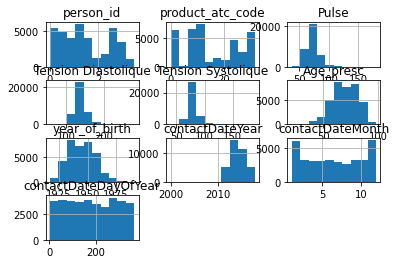

In [20]:
dfWithTime.hist()

### Conversion en ```TimeSeries```

Nous définissons simplement le nouvel index comme la colonne donnant l'intervalle de temps entre chaque visite.

In [21]:
ts = dfWithTime.set_index(['person_id','contact_date']).sort_index()
ts

product_atc_code  ...  contactDateDayOfYear
person_id  contact_date                    ...                      
291.0      2016-10-28                  10  ...                   302
           2016-11-04                  10  ...                   309
           2016-11-21                  10  ...                   326
           2017-01-16                  10  ...                    16
           2017-11-20                  10  ...                   324
...                                   ...  ...                   ...
34823672.0 2017-04-15                   8  ...                   105
           2017-06-26                   8  ...                   177
           2017-08-30                   8  ...                   242
           2017-09-11                   8  ...                   254
           2018-08-02                   8  ...                   214

[36876 rows x 10 columns]

### Attribution des bonnes valeurs de ```time_wait```

In [22]:
tsWithTime = ts.copy()
for i,_ in ts.groupby('person_id'):
    len_ = len(ts.loc[i])
    tsWithTime.loc[i].wait_time[1:len_] = pd.Series(ts.loc[i].wait_time.to_numpy()[1:len_] - ts.loc[i].wait_time.to_numpy()[:len_-1])
    tsWithTime.loc[i].wait_time[0] = pd.Timedelta(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
tsWithTimeNumber = tsWithTime.copy()
tsWithTimeNumber.wait_time = tsWithTime.wait_time.dt.days
tsWithTimeNumber['wait_time_days'] = tsWithTime.wait_time.dt.days
tsWithTimeNumber['wait_time_weeks'] = (tsWithTime.wait_time.dt.days / 7).astype(int)
tsWithTimeNumber.wait_time.describe()

count    36876.000000
mean       104.590520
std        122.973534
min          0.000000
25%         26.000000
50%         76.000000
75%        139.000000
max       2825.000000
Name: wait_time, dtype: float64

In [24]:
tsWithGoodTime = tsWithTimeNumber[tsWithTimeNumber.wait_time.values <= 300]
tsWithGoodTime.wait_time.describe()

count    34546.00000
mean        81.39967
std         73.03593
min          0.00000
25%         23.00000
50%         67.00000
75%        118.00000
max        300.00000
Name: wait_time, dtype: float64

### Transformation de ```wait_time``` en valeur numérique

In [25]:
tsWithTimeMonth = tsWithGoodTime.copy()
tsWithTimeMonth.wait_time = (tsWithGoodTime.wait_time / 30).astype(int)
tsWithTimeMonth.wait_time[tsWithTimeMonth.wait_time >= 4] = 4
tsWithTimeMonth

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


product_atc_code  ...  wait_time_weeks
person_id  contact_date                    ...                 
291.0      2016-10-28                  10  ...                0
           2016-11-04                  10  ...                1
           2016-11-21                  10  ...                2
           2017-01-16                  10  ...                8
           2018-01-19                  10  ...                8
...                                   ...  ...              ...
34782602.0 2018-02-14                   8  ...               10
34823672.0 2017-04-15                   8  ...                0
           2017-06-26                   8  ...               10
           2017-08-30                   8  ...                9
           2017-09-11                   8  ...                1

[34546 rows x 12 columns]

In [28]:
tsResetIndex = tsWithTimeMonth.copy()
tsResetIndex = tsResetIndex.reset_index()
print( tsResetIndex )
tsValueCounts = tsResetIndex.person_id.value_counts()
tsIndexed = tsResetIndex[tsResetIndex.person_id.isin(tsValueCounts[tsValueCounts.values >= VISIT_NUMBER].index)]

        person_id contact_date  ...  wait_time_days  wait_time_weeks
0           291.0   2016-10-28  ...               0                0
1           291.0   2016-11-04  ...               7                1
2           291.0   2016-11-21  ...              17                2
3           291.0   2017-01-16  ...              56                8
4           291.0   2018-01-19  ...              60                8
...           ...          ...  ...             ...              ...
34541  34782602.0   2018-02-14  ...              76               10
34542  34823672.0   2017-04-15  ...               0                0
34543  34823672.0   2017-06-26  ...              72               10
34544  34823672.0   2017-08-30  ...              65                9
34545  34823672.0   2017-09-11  ...              12                1

[34546 rows x 14 columns]


In [29]:
atcCodeValues = tsWithTimeMonth.product_atc_code
waitTimeValues = tsWithTimeMonth.wait_time

tsFinal = pd.concat([tsWithTimeMonth,pd.get_dummies(atcCodeValues),pd.get_dummies(waitTimeValues)],axis='columns').drop(['product_atc_code','wait_time'],axis='columns')

# Prédiction

## Création des données d'entraînement/test

In [ ]:
#yColumnNames = ['product_atc_code', 'wait_time']

#xList,yList = [],[]
#for i,_ in tsWithTimeMonth.groupby('person_id'):
    # Mme ZERHAOUI a dit qu'il fallait transposer, je transpose
    # Pour l'instant je retourne au model évident : une série temporel qui contient 4 éléments de n_features données, on verra après pour la trasposition
#    currentSeriesX = tsFinal.loc[i]
#    currentSeriesY = tsWithTimeMonth.loc[i]
#    for j in range(0,len(currentSeriesX)-VISIT_NUMBER+1):
#        xList.append(currentSeriesX[j:j+VISIT_NUMBER-1].to_numpy().astype('float32'))
        #xList.append(currentSeries.to_numpy().astype('float32'))
#        yList.append(currentSeriesY[yColumnNames].values[j+VISIT_NUMBER-1].astype('float32'))
        #yList.append(currentSeries[yColumnNames].astype('float32'))

#xData = np.array(xList).reshape((len(xList),xList[0].shape[0],xList[0].shape[1]))
#yData = np.array(yList).reshape((len(yList),len(yColumnNames)))

In [ ]:
yColumnNames = ['product_atc_code', 'wait_time']
xList,yList = [],[]
for i,_ in tsWithTimeMonth.groupby('person_id'):
    if(len(tsFinal.loc[i]) >= 5):
        xList.append(tsFinal.loc[i][:5][:-1].to_numpy().astype('float32'))
        yList.append(tsWithTimeMonth[yColumnNames].loc[i][:5][-1:].to_numpy().astype('float32'))

In [ ]:
xData = np.array(xList)
yData = np.array(yList)

xs = xData.shape
ys = yData.shape

xData = xData.reshape(xs[0],1,xs[1],xs[2])
yData = yData.reshape(ys[0],ys[1],ys[2])

In [ ]:
print(f"{xData.shape} --- {yData.shape}")

In [ ]:
l = len(xData) // 2
xData1, yData1 = xData[:l], yData[:l]
xData2, yData2 = xData[:-l], yData[:-l]

In [ ]:
trainUse1 = int(len(xData1) * 2 / 3)
testUse1 = len(xData1) - trainUse1

xTrain1, xTest1, yTrain1, yTest1 = xData1[:trainUse1],xData1[-testUse1:],yData1[:trainUse1],yData1[-testUse1:]

print(f"Train: {xTrain1.shape} --- Test: {xTest1.shape}")

In [ ]:
#Cellule pour faire des tests et comprendre la syntaxe que j'ai utilisée après
L = [[1,2,3,4,5,6],[7,8,9],[10,11]]
for l in L:
    # -2: permet d'avoir les deux derniers
    # :le-2 permet d'avoir toutes les entrées sauf les deux dernières
    print(f"{l[-2:]} | {l[:-2]}")

In [ ]:
print(xData2.shape, "   ", yData2.shape)

In [ ]:
xTrain2, xTest2, yTrain2, yTest2 = xData2[:,:,:-2,:],xData2[:,:,-2:,:],yData2[:,:-2,:],yData2[:,-2:,:]

In [ ]:
yTrain2.shape

In [ ]:
yTrain1.shape

## Création du modèle

In [ ]:
ATC_CODE = 0
WAIT_TIME = 1
toTrain = ATC_CODE

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(filters=256,kernel_size=3, activation=None, input_shape=(VISIT_NUMBER-1,xTrain.shape[-1])))
model.add(layers.LeakyReLU())
model.add(layers.GaussianDropout(0.05))
model.add(layers.Conv1D(filters=256,kernel_size=3, padding="same", activation=None))
model.add(layers.LeakyReLU())
model.add(layers.GaussianDropout(0.05))
model.add(layers.Conv1D(filters=128,kernel_size=3, padding="same", activation=None))
model.add(layers.LeakyReLU())
model.add(layers.GaussianDropout(0.05))
model.add(layers.GlobalMaxPooling1D())
if toTrain == ATC_CODE:
    model.add(layers.Dense(units=len(ATCEncoder.classes_),activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.Dense(units=len(ATCEncoder.classes_),activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.Dense(units=len(ATCEncoder.classes_),activation='softmax'))
elif toTrain == WAIT_TIME:
    model.add(layers.Dense(units=tsWithTimeMonth.wait_time.max()+1,activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.Dense(units=tsWithTimeMonth.wait_time.max()+1,activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.Dense(units=tsWithTimeMonth.wait_time.max()+1,activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
history = model.fit(xTrain1,yTrain1[:,:,toTrain],epochs=100,validation_data=(xTest1,yTest1[:,:,toTrain]))
#history = model.fit(xTrain2,yTrain2[:,:,toTrain],epochs=30,validation_data=(xTest2,yTest2[:,:,toTrain]))

In [ ]:
loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

## As loss always exists
epochs = range(1,len(history.history[loss_list[0]]) + 1)

fig, (p1,p2) = plt.subplots(1,2,figsize=(13,4))

## Loss
for l in loss_list:
    p1.plot(epochs, history.history[l], 'b', label='Training loss')
for l in val_loss_list:
    p1.plot(epochs, history.history[l], 'g', label='Validation loss')

p1.set(xlabel='Epochs',ylabel='Loss')

## Accuracy
for l in acc_list:
    p2.plot(epochs, history.history[l], 'b', label='Training accuracy')
for l in val_acc_list:    
    p2.plot(epochs, history.history[l], 'g', label='Validation accuracy')

p1.set(xlabel='Epochs',ylabel='Accuracy')
plt.legend()
plt.show()

In [ ]:
yTest = yTest1
predictions = np.argmax(model.predict(xTest1),axis=1).reshape(yTest[:,:,toTrain].shape)
print(f"Précision '{yColumnNames[toTrain]}': {(predictions == yTest[:,:,toTrain]).sum()/len(yTest)*100:.2f}%")

In [ ]:
SLICE_START = 200
SLICE_SIZE = 50
SLICE_END = SLICE_START + SLICE_SIZE

plt.plot(yTest[SLICE_START:SLICE_END,:,toTrain],label='expected')
plt.plot(predictions[SLICE_START:SLICE_END,0],color='r',label='predicted')

fig.legend()
fig.show()